# CTA first data challenge (1DC) with Gammapy

## Introduction

The [CTA observatory](https://www.cta-observatory.org/) has started a first data challenge ("CTA 1DC"), focusing on high-level data analysis. Gammapy is a prototype for the CTA science tools (see [Gammapy proceeding from ICRC 2017](https://github.com/gammapy/icrc2017-gammapy-poster/blob/master/proceeding/gammapy-icrc2017.pdf)), and while many things are work in progress (most importantly: source and background modeling and cube analysis), you can use it already to analyse the simulated CTA data.

The main page for CTA 1DC is here:
https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki (CTA internal)

There you will find information on 1DC sky models, data access, data organisation, simulation and analysis tools, simulated observations, as well as contact information if you have any questions or comments.

**This notebook shows you how to get started with CTA 1DC data and what it contains. You will learn how to access event data, IRFs and index files with Gammapy, and how to select the subset of observations you're interested in.**

**You can also just skim this notebook, or only go over the first two sections to make sure you have Gammapy and CTA 1DC data set up OK, and then go straight to the "cta_data_analysis.ipynb" notebook to learn how to make a sky image and spectrum.**

For further information how to do data analysis with Gammapy, please see the other tutorial notebooks. If you have a Gammapy-related question, please send an email to to Gammapy mailing list at http://groups.google.com/group/gammapy (registration required) or if you have an issue or feature request, file an issue here: https://github.com/gammapy/gammapy/issues/new (free Github account required, takes 1 min to set up).

Please note that the 1DC data isn't public and results should be shared on CTA Redmine, as described here: https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki#Sharing-of-analysis-results

## Notebook and Gammapy Setup

Before we get started, please execcute the following code cells.

The first one configures the notebooks so that plots are shown inline (if you don't do this, separate windows will pop up). The second cell imports and checks the version of the packages we will use below. If you're missing some packages, install them and then select "Kernel -> Restart" above to restart this notebook.

In case you're new to Jupyter notebooks: to execute a cell, select it, then type "SHIFT" + "ENTER".

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy

print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('gammapy:', gammapy.__version__)

numpy: 1.13.1
astropy: 3.0.dev19816
gammapy: 0.6


## Getting the 1DC data

You can find infos how to download the 1DC data here: 
https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki#Data-access

Overall it's quite large (20 GB) and will take a while to download. You can just download a subset of the "gps", "gc", "egal" or "agn" datasets, the ones you're interested in. In this tutorial, we will only use the "gc" (Galactic center) dataset, so maybe you could start by downloading that first.

While you wait, we strongly recommend you go over some [CTA basics](https://www.youtube.com/playlist?list=PLq3ItKoU0hy7ED6m1eve6WIFs7ibcv3YR) as well as some [Python basics](https://www.youtube.com/playlist?list=PL-Qryc-SVnnu0tPV623TFnrAEQLykkZF5) to prepare yourself for this tutorial.

Got the data?

Assuming you've followed the instructions, you should have the ``CTADATA`` environment variable pointing to the folder where all data is located. (Gammapy doesn't need or use the ``CALDB`` environment variable.)


In [3]:
!echo $CTADATA

/Users/deil/work/cta-dc/data/1dc/1dc


In [4]:
!ls $CTADATA

caldb  data   index  models obs


You can find a description of the directories and files here:
https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki/Data_organisation

A very detailed specification of the data formats is here:
http://gamma-astro-data-formats.readthedocs.io/

But actually, instead of reading those pages, let's just explore the data and see how to load it with Gammapy ...

Before we start, just in case the commands above show that you don't have `CTADATA` set:
* you either have to exit the "jupyter notebook" command on your terminal, set the environment variable (I'm using bash and added the command `export CTADATA=/Users/deil/work/cta-dc/data/1dc/1dc` to my `~/.profile` file and then did `source ~/.profile`), then re-start Jupyter and this notebook.
* or you can set the environment variable by uncommentting the code in the following cell, setting the correct path, then executing it.

In [5]:
# import os
# os.environ['CTADATA'] = '/Users/deil/work/cta-dc/data/1dc/1dc'
# !echo $CTADATA
# !ls $CTADATA

## Overview of 1DC data files

Let's have a look around at the directories and files in `$CTADATA`.

We will look at the `data` folder with events, the `caldb` folder with the IRFs and the `index` folder with the index files. At the end, we will also mention what the `model` and `obs` folder contains, but they aren't used with Gammapy, at least not at the moment.

### EVENT data

First, the EVENT data (RA, DEC, ENERGY, TIME of each photon or hadronic background event) is in the `data/baseline` folder, with one observation per file. The "baseline" refers to the assumed CTA array that was used to simulate the observations. The number in the filename is the observation identifier `OBS_ID` of the observation. Observations are ~ 30 minutes, pointing at a fixed location on the sky.

In [6]:
!ls $CTADATA

caldb  data   index  models obs


In [7]:
!ls $CTADATA/data/baseline

agn  egal gc   gps


In [8]:
!ls $CTADATA/data/baseline/gc | head -n3

gc_baseline_310000.fits
gc_baseline_310001.fits
gc_baseline_310002.fits


In [9]:
# There's 1671 observations and 5.9 GB of event data for the Galactic center "gc" survey
!ls $CTADATA/data/baseline/gc | wc -l
!du -hs $CTADATA/data/baseline/gc

    1671
5.9G	/Users/deil/work/cta-dc/data/1dc/1dc/data/baseline/gc


Let's open up the first event list using the Gammapy `EventList` class, which contains the ``EVENTS`` table data via the ``table`` attribute as an Astropy `Table` object.

In [10]:
from gammapy.data import EventList
events = EventList.read('$CTADATA/data/baseline/gc/gc_baseline_310000.fits')
print(type(events))
print(type(events.table))

<class 'gammapy.data.event_list.EventList'>
<class 'astropy.table.table.Table'>


In [11]:
# First event (using [] for "indexing")
events.table[0]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,662774401.496,-94.4147,-30.1971,0.0338345,0.10751,-1.04139,2


In [12]:
# First few events (using [] for "slicing")
events.table[:3]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,662774401.496,-94.4147,-30.1971,0.0338345,0.10751,-1.04139,2
2,662774405.43,-92.982,-28.3259,0.0540774,1.98403,0.200576,2
3,662774406.325,-93.1449,-29.5099,0.0422171,0.800156,0.0565139,2


In [13]:
# Event times can be accessed as Astropy Time objects
print(type(events.time))

<class 'astropy.time.core.Time'>


In [14]:
events.time[:3]

<Time object: scale='tt' format='mjd' value=[ 59215.50001731  59215.50006284  59215.50007321]>

In [15]:
# Convert event time to more human-readable format
print(events.time[:3].fits)

['2021-01-01T12:00:01.496(TT)' '2021-01-01T12:00:05.430(TT)'
 '2021-01-01T12:00:06.325(TT)']


In [16]:
# Event positions can be accessed as Astropy SkyCoord objects
print(type(events.radec))
events.radec[:2]

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>


<SkyCoord (ICRS): (ra, dec) in deg
    [( 265.58529663, -30.19706917), ( 267.01800537, -28.32586861)]>

In [17]:
events.galactic[:2]

<SkyCoord (Galactic): (l, b) in deg
    [( 358.55250415, -0.05350589), (   0.80089378, -0.14331195)]>

In [18]:
# The event header information is stored
# in the `events.table.meta` dictionary
print(type(events.table.meta))
# E.g. to get the observation pointing position in degree:
events.table.meta['RA_PNT'], events.table.meta['DEC_PNT']

<class 'collections.OrderedDict'>


(266.79019165, -30.3101)

<SkyCoord (Galactic): (l, b) in deg
    ( 359.00001833, -0.99995901)>

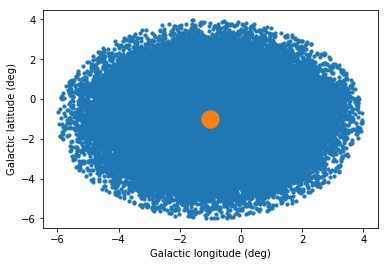

In [19]:
# To illustrate a bit how to work with EVENT table an header data,
# let's plot the event positions as well as the pointing position
pos = events.galactic[::1]
plt.scatter(pos.l.wrap_at('180 deg').deg, pos.b.deg, s=10)
# Pointing position
pos_pnt = events.pointing_radec.galactic
plt.scatter(pos_pnt.l.wrap_at('180 deg').deg, pos_pnt.b.deg, s=300)
plt.xlabel('Galactic longitude (deg)')
plt.ylabel('Galactic latitude (deg)')
pos_pnt

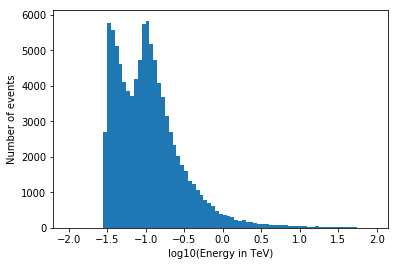

In [20]:
# Let's have a look at the energy distribution of the events
import numpy as np
t = events.table
offset = np.sqrt(t['DETX'].data ** 2 + t['DETY'].data ** 2)
# mask  = (offset < 0.3)
# t = t[mask]
is_bkg = t['MC_ID'] == 1
values = np.log10(t['ENERGY'])
bins=np.arange(-2, 2, 0.05)
plt.hist(values[is_bkg], bins, label='bkg');
# plt.hist(values[~is_bkg], bins, label='photons');
plt.xlabel('log10(Energy in TeV)')
plt.ylabel('Number of events')

## Work in progress

TODO: write the rest of this notebook.

In [21]:
# events.table.meta

## Index files

bla

In [22]:
import os
data_store = DataStore.from_dir(CTADATA)
data_store.info()

NameError: name 'DataStore' is not defined

In [ ]:
print(data_store.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT']
data_store.obs_table[::100][obs_colnames]

## Select observations

To have something small and quick to play around with, let's just select three runs.

Since we'll use the reflected regions background estimation method below to compute a spectrum,
we'll select runs at a good distance to the target (the Galactic center source).

In [ ]:
def select_obs():
    t = data_store.obs_table.copy()
    pos_run = SkyCoord(t['GLON_PNT'], t['GLAT_PNT'], unit='deg', frame='galactic')
    pos_target = SkyCoord(0, 0, unit='deg', frame='galactic')
    d = pos_target.separation(pos_run).degree
    mask = (0 <= d) & (1 < d)
    return list(t[mask]['OBS_ID'])

obs_ids = select_obs()[:3]
print(obs_ids)
obs_list = data_store.obs_list(obs_ids)

In [ ]:
data_store.obs_table.select_obs_id(obs_ids)[obs_colnames]

In [ ]:
obs = obs_list[0]

In [ ]:
print(obs)

In [ ]:
obs.events.peek()

In [ ]:
obs.aeff.peek()

In [ ]:
obs.edisp.peek()

In [ ]:
obs.psf.peek()

## Exercises

tbd

## What next?

* This notebook gave you an overview of the 1DC files and showed you have to access and work with them using Gammapy.
* To see how to do analysis, i.e. make a sky image and spectrum, see ``cta_data_analysis.ipynb`` next.